In [1]:
from __future__ import print_function

import sys
import os
import time
from PIL import Image
import numpy as np
import theano
import theano.tensor as T
import cPickle as pickle
import lasagne

Using gpu device 0: GeForce 820M (CNMeM is disabled, cuDNN not available)
C:\Users\admin\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
def load_data(path):
    x_train = np.zeros((50000, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((50000,), dtype="uint8")

    for i in range(1, 6):
        data = unpickle(os.path.join(path, 'data_batch_' + str(i)))
        images = data['data'].reshape(10000, 3, 32, 32)
        labels = data['labels']
        x_train[(i - 1) * 10000:i * 10000, :, :, :] = images
        y_train[(i - 1) * 10000:i * 10000] = labels
    x_train, x_val = x_train[:-10000], x_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    test_data = unpickle(os.path.join(path, 'test_batch'))
    x_test = test_data['data'].reshape(10000, 3, 32, 32)
    y_test = np.array(test_data['labels'])

    return x_train, y_train, x_val, y_val, x_test, y_test
 
def unpickle(file):
    f = open(file, 'rb')
    dict = pickle.load(f)
    f.close()
    return dict

In [3]:
x_train, y_train, x_val, y_val, x_test, y_test=load_data(os.path.expanduser('F:/pandas-ex/mnist-test/cifar-10-batches-py'))

In [4]:
def build_cnn(input_var=None):
    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),
                                        input_var=input_var)
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=16, filter_size=(5, 5),
            stride=1, pad=2,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2), stride=2)

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=20, filter_size=(5, 5),
            stride=1, pad=2,
            nonlinearity=lasagne.nonlinearities.rectify)

    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2), stride=2)

    network = lasagne.layers.Conv2DLayer(
            network, num_filters=20, filter_size=(5, 5),
            stride=1, pad=2,
            nonlinearity=lasagne.nonlinearities.rectify)

    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2), stride=2)

    # 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            network,
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [5]:
def iterate_minibatches(inputs, targets, batchsize=4, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [6]:
def main(model='cnn', num_epochs=100):
    # Load the dataset
    print("Loading data...")

    X_train, y_train, X_val, y_val, X_test, y_test = load_data(os.path.expanduser('F:/pandas-ex/mnist-test/cifar-10-batches-py'))


    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    if model == 'cnn':
        network = build_cnn(input_var)
    else:
        print("Unrecognized model type %r." % model)

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
  
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

 
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 100, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 10, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 100, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))

    # Optionally, you could now dump the network weights to a file like this:
    np.savez('cifar_weights-new.npz', *lasagne.layers.get_all_param_values(network))
    #
    # And load them again later on like this:
    # with np.load('model.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)

In [8]:
with np.load('cifar_weights-new.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)

NameError: name 'network' is not defined

In [13]:
network=build_cnn()

In [14]:
with np.load('cifar_weights-new.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)

In [7]:
main(model='cnn', num_epochs=100)

Loading data...
Building model and compiling functions...

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/admin/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.8-64/tmpxfcmfh/03ad6326ed42c8924f9c25bb41c2c592.lib and object C:/Users/admin/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.8-64/tmpxfcmfh/03ad6326ed42c8924f9c25bb41c2c592.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/admin/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.8-64/tmpocundk/83722044baa691e622cc46115b5211dd.lib and object C:/Users/admin/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.8-64/tmpocundk/83722044baa691e622cc46115b5211dd.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/admin/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.8-64/tmpm0jwxx/ac5b1d906b09284


Starting training...
Epoch 1 of 100 took 67.068s
  training loss:		122.950407
  validation loss:		2.303074
  validation accuracy:		9.77 %
Epoch 2 of 100 took 77.363s
  training loss:		2.302857
  validation loss:		2.302888
  validation accuracy:		9.77 %
Epoch 3 of 100 took 78.493s
  training loss:		2.302889
  validation loss:		2.302941
  validation accuracy:		9.52 %
Epoch 4 of 100 took 78.575s
  training loss:		2.302877
  validation loss:		2.303080
  validation accuracy:		9.80 %
Epoch 5 of 100 took 78.980s
  training loss:		2.302857
  validation loss:		2.302641
  validation accuracy:		10.25 %
Epoch 6 of 100 took 78.944s
  training loss:		2.302977
  validation loss:		2.302932
  validation accuracy:		9.77 %
Epoch 7 of 100 took 78.087s
  training loss:		2.302952
  validation loss:		2.302796
  validation accuracy:		9.52 %
Epoch 8 of 100 took 79.950s
  training loss:		2.302883
  validation loss:		2.302693
  validation accuracy:		10.14 %
Epoch 9 of 100 took 78.215s
  training loss:		2.302924

 mod.cu
   Creating library C:/Users/admin/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.8-64/tmpkpu5sn/898656a16df74943c0ae74947599b14c.lib and object C:/Users/admin/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.8-64/tmpkpu5sn/898656a16df74943c0ae74947599b14c.exp



In [8]:
train_loss = np.array([i["train_loss"] for i in network.train_history_])
valid_loss = np.array([i["valid_loss"] for i in network.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

NameError: name 'network' is not defined

In [11]:
network.train_histroy_1

NameError: name 'network' is not defined

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 10 took 86.326s
  training loss:		6.093847
  validation loss:		2.302898
  validation accuracy:		9.77 %
Epoch 2 of 10 took 83.410s
  training loss:		2.302851
  validation loss:		2.302641
  validation accuracy:		10.16 %
Epoch 3 of 10 took 84.026s
  training loss:		2.302920
  validation loss:		2.302696
  validation accuracy:		9.78 %
Epoch 4 of 10 took 86.760s
  training loss:		2.302929
  validation loss:		2.302615
  validation accuracy:		9.77 %
Epoch 5 of 10 took 88.910s
  training loss:		2.302889
  validation loss:		2.302672
  validation accuracy:		10.25 %
Epoch 6 of 10 took 86.742s
  training loss:		2.302839
  validation loss:		2.302621
  validation accuracy:		10.22 %
Epoch 7 of 10 took 88.988s
  training loss:		2.302880
  validation loss:		2.302754
  validation accuracy:		9.78 %
Epoch 8 of 10 took 89.165s
  training loss:		2.302870
  validation loss:		2.302770
  validation accuracy:		9.52 %
Epoch 

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/admin/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.8-64/tmpdqhpst/3d70cbb939df1d1403da7ec43a15c606.lib and object C:/Users/admin/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-2.7.8-64/tmpdqhpst/3d70cbb939df1d1403da7ec43a15c606.exp



In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
def displayImage(image):
    img=np.ascontiguousarray(image.transpose(1,2,0))
    img = Image.fromarray(img, 'RGB')
    plt.imshow(img)
    plt.show()

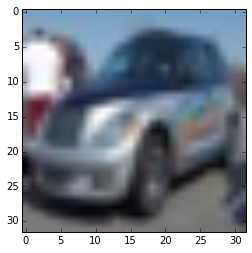

In [25]:
displayImage(x_train[112])

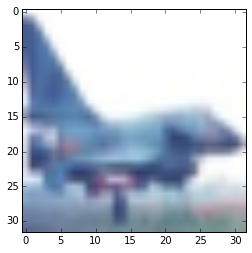

In [28]:
displayImage(x_val[12])

In [29]:
y_val[12]

0

In [30]:
y_val[13]

1

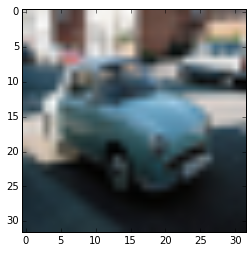

In [31]:
displayImage(x_val[3])

In [10]:
net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 32, 32),
    #Layer-1 Convolution
    conv1_num_filters=32, conv1_filter_size=(5, 5), conv1_nonlinearity=lasagne.nonlinearities.rectify,

    #Layer-2 Pooling
    pool1_pool_size=(2, 2),

    #Layer-3 Convolution
    conv2_num_filters=32, conv2_filter_size=(5, 5), conv2_nonlinearity=lasagne.nonlinearities.rectify,

    #Layer-4 pooling
    pool2_pool_size=(2, 2),

    #Layer-5 Convolution
    conv3_num_filters=64, conv3_filter_size=(5, 5), conv3_nonlinearity=lasagne.nonlinearities.rectify,

    #Layer-5 Dense Layer1 and Layer2
    hidden4_num_units=64, hidden4_nonlinearity=lasagne.nonlinearities.linear,
	hidden5_num_units=10, hidden5_nonlinearity=lasagne.nonlinearities.rectify,

    #Layer-8 Output Layer
    output_num_units=10, output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.001,
    update_momentum=0.9,

    regression=True,
    max_epochs=100,
    verbose=1,
    )


NameError: name 'NeuralNet' is not defined

In [5]:
x_train, y_train, x_test, y_test = load_data(os.path.expanduser('F:/pandas-ex/mnist-test/cifar-10-batches-py'))

In [ ]:
network = net2.fit(x_train, y_train)
predictions = network.predict(x_test)